In [1]:
import os
import re
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
import jax
import flax
from flax import nn, optim, serialization

In [3]:
from lib.params import mdn

In [4]:
path_data = './mcsamples'
path_models = './dat'

In [5]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [6]:
def smeared_samp_file(re, im, ch):
    return f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy'

In [7]:
def get_sample(re, im, ch):
    return get_vars(np.load(os.path.join(path_data, smeared_samp_file(re, im, ch))))

In [8]:
def draw_1d_projections(ax, data, bins=250, weights=None, alpha=None, density=False, lims=None, label=None):
    if not lims:
        lims = [(-3, 10), (0, 150), (2.004, 2.016)]
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for idx, (lbl, l) in enumerate(zip(labels, lims)):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights, alpha=alpha, density=density, range=l, label=label);
        if label:
            ax[idx].legend()
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [9]:
parset = [(44, 1.1 + idx*0.1) for idx in range(9)]
parset

[(44, 1.1),
 (44, 1.2000000000000002),
 (44, 1.3),
 (44, 1.4000000000000001),
 (44, 1.5),
 (44, 1.6),
 (44, 1.7000000000000002),
 (44, 1.8000000000000003),
 (44, 1.9000000000000001)]

In [10]:
samples = [get_sample(*p, 250)[:80000] for p in parset]
sum(map(len, samples))

720000

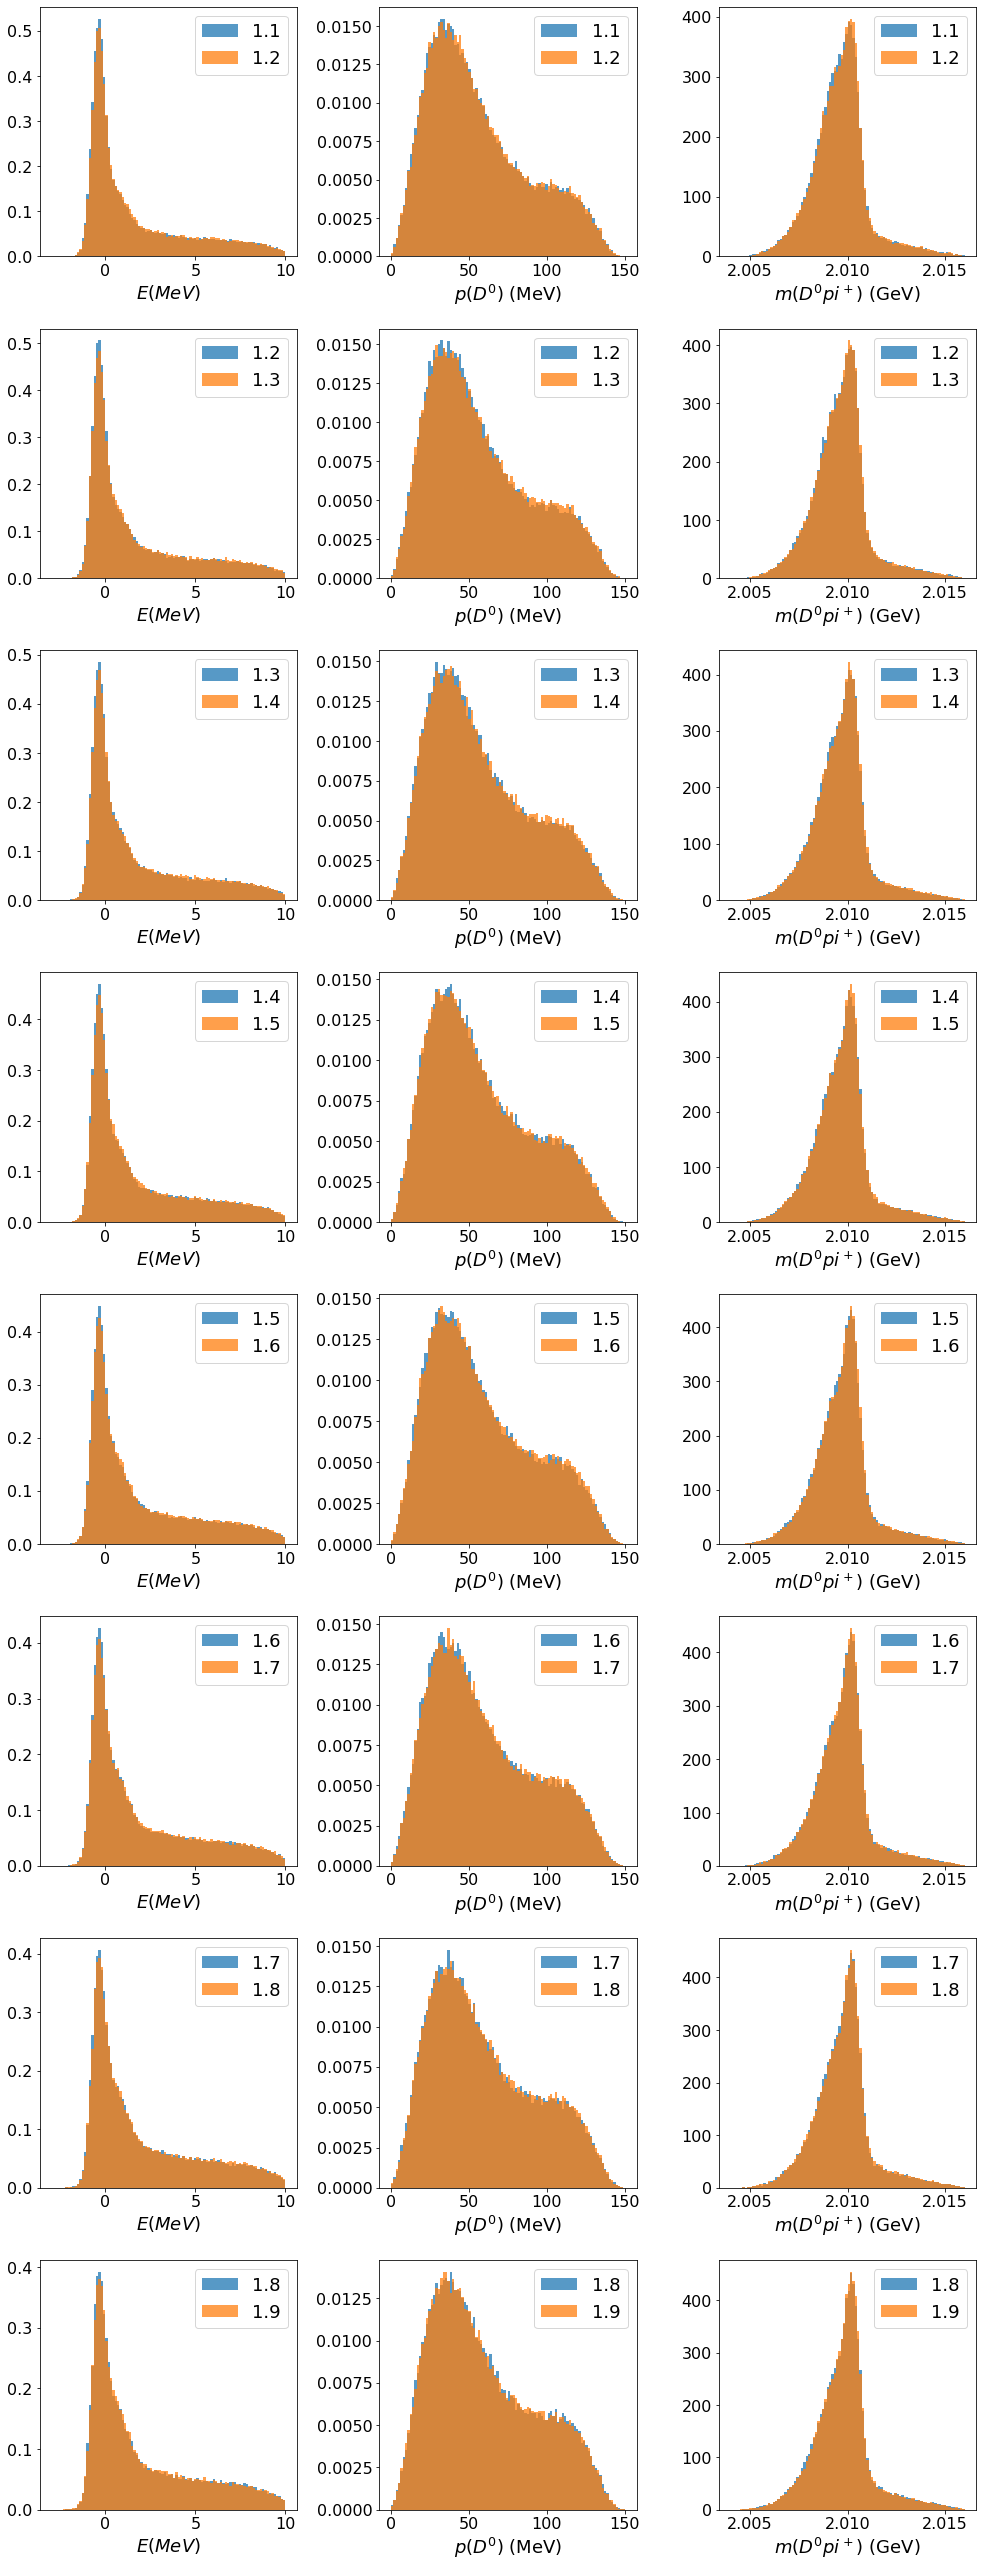

In [11]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(14, 4.5*8))
for idx, axrow in enumerate(ax):
    draw_1d_projections(axrow, samples[idx], bins=100, weights=None, alpha=0.75, density=True, label=f'{1.1+idx*0.1:.1f}')
    draw_1d_projections(axrow, samples[idx+1], bins=100, weights=None, alpha=0.75, density=True, label=f'{1.2+idx*0.1:.1f}');
fig.tight_layout()

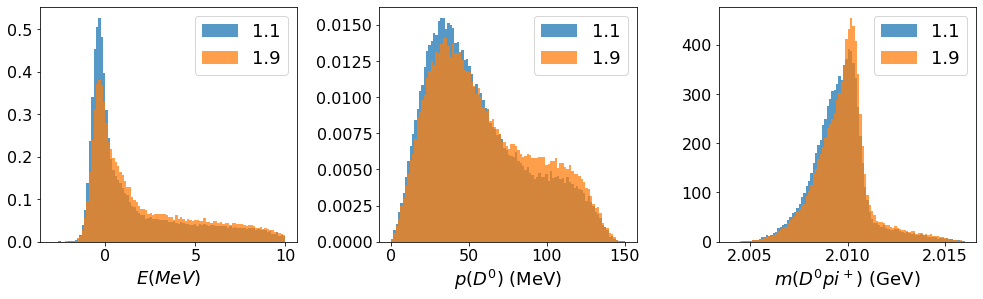

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, samples[0], bins=100, weights=None, alpha=0.75, density=True, label='1.1')
draw_1d_projections(ax, samples[-1], bins=100, weights=None, alpha=0.75, density=True, label='1.9');
fig.tight_layout()

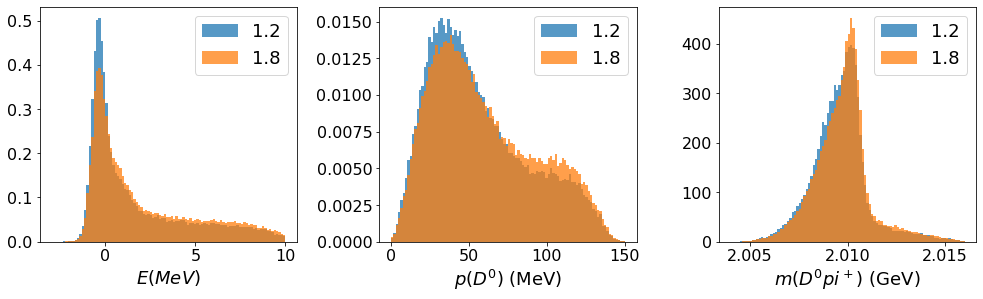

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, samples[1], bins=100, weights=None, alpha=0.75, density=True, label='1.2')
draw_1d_projections(ax, samples[-2], bins=100, weights=None, alpha=0.75, density=True, label='1.8');
fig.tight_layout()

In [14]:
def uniform_sample(rg, limits, N):
    """ """
    lo = [x[0] for x in limits]
    hi = [x[1] for x in limits]
    return rg.uniform(lo, hi, (N, len(limits)))

In [15]:
def norm_sample(rg, samp, mult=10):
    norm_size = mult*samp.shape[0]
    limits = [[np.min(samp[:, i]), np.max(samp[:, i])] for i in range(samp.shape[1])]
    return uniform_sample(rg, limits, norm_size)

In [16]:
rg = np.random.Generator(np.random.PCG64())

In [17]:
norm = norm_sample(rg, samples[-1], mult=100)
norm.shape

(8000000, 3)

In [18]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=16)
        x = nn.relu(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)
    
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer
        
def model_file(re, im, ch):
    return f'nn_model_3d_gs{re:.2f}_{im:.2f}_ch{ch}.dat'

def norm_file(re, im, ch):
    return f'norm_gs{re:.2f}_{im:.2f}_ch{ch}.npz'

def get_norm(re, im, ch):
    fname = os.path.join(path_models, norm_file(re, im, ch))
    if not os.path.isfile(fname):
        print('get_norm: {fname} not found')
    ndata = np.load(fname)
    return (ndata['mean'], ndata['std'])

def read_model(re, im, ch):
    key = jax.random.PRNGKey(0)
    _, initial_params = NN.init(key, np.zeros((10, 3)))
    
    model = nn.Model(NN, initial_params)
    
    adam = optim.Adam(learning_rate=0.003)
    optimizer = adam.create(model)
    
    state = TrainState(optimizer=optimizer)
    means, stds = get_norm(re, im, ch)
        
    with open(os.path.join(path_models, model_file(re, im, ch)), 'rb') as f:
        data = f.read()
        
    restored_state = flax.serialization.from_bytes(state, data)
    jax.tree_map(np.shape, flax.serialization.to_state_dict(restored_state))
        
    model = nn.Model(NN, initial_params)
    for layer in range(4):
        model.params[f'Dense_{layer}'] =\
            restored_state.optimizer.state_dict()['target']['params'][f'Dense_{layer}']
        
    def pdf(data):
        norm_data = np.empty(data.shape)
        for idx, (m, s) in enumerate(zip(means, stds)):
            norm_data[:, idx] = (data[:, idx] - m) / s
        return np.array(model(norm_data))
    return pdf

In [19]:
models = [read_model(*p, 250) for p in parset]

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


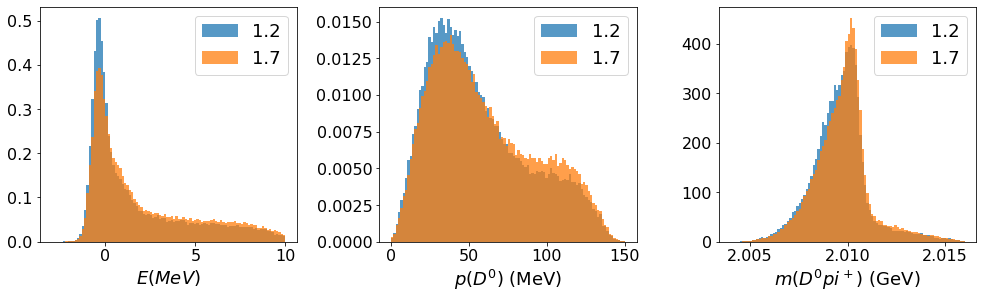

In [74]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, samples[1], bins=100, weights=None, alpha=0.75, density=True, label='1.2')
draw_1d_projections(ax, samples[-2], bins=100, weights=None, alpha=0.75, density=True, label='1.7');
fig.tight_layout()
plt.savefig('plots/s1.2_vs_s1.7.png')

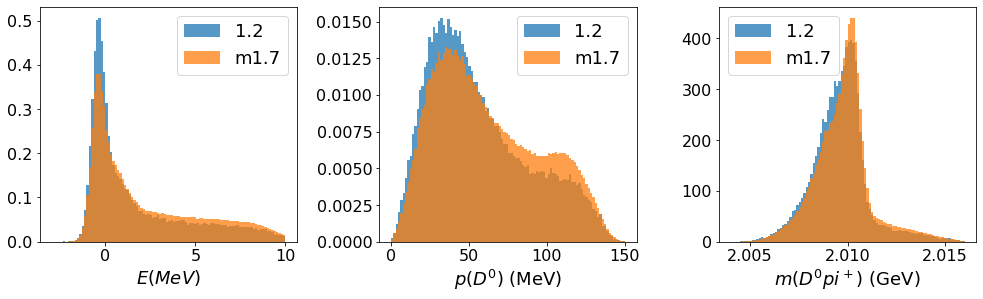

In [73]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, samples[1], bins=100, weights=None, alpha=0.75, density=True, label='1.2')
draw_1d_projections(ax, norm, bins=100, weights=models[-2](norm), alpha=0.75, density=True, label='m1.7');
fig.tight_layout()
plt.savefig('plots/s1.2_vs_m1.7.png')

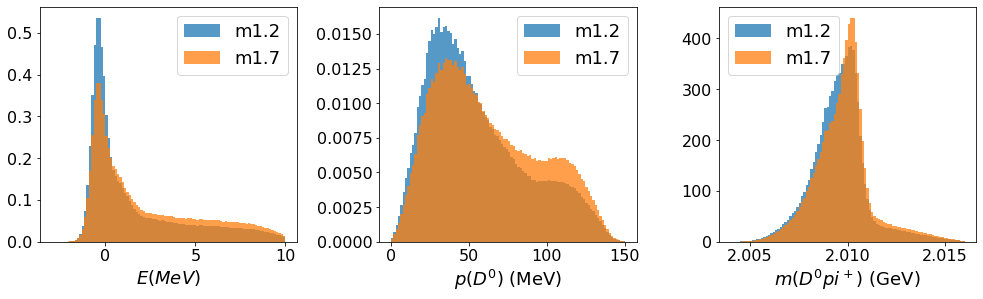

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, norm, bins=100, weights=models[1](norm), alpha=0.75, density=True, label='m1.2')
draw_1d_projections(ax, norm, bins=100, weights=models[-2](norm), alpha=0.75, density=True, label='m1.7');
fig.tight_layout()
plt.savefig('plots/m1.2_vs_m1.7.png')

In [20]:
def unbinned_loglh(model, sample, norm):
    return -np.sum(np.log(model(sample))) + sample.shape[0] * (np.log(np.mean(model(norm))))

In [61]:
print(list(map(len, samples)))

[80000, 80000, 80000, 80000, 80000, 80000, 80000, 80000, 80000]


In [66]:
idx, jdx = 1, -2
N = len(samples[idx])
yi = [unbinned_loglh(models[k], samples[idx], norm) / N for k in [idx, jdx]]
yj = [unbinned_loglh(models[k], samples[jdx], norm) / N for k in [idx, jdx]]

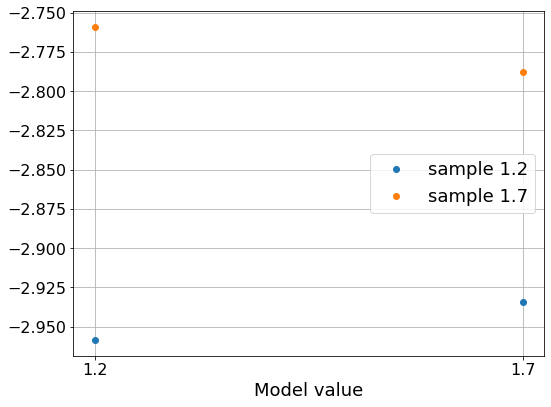

In [71]:
x = [1.1 + 0.1 * (x%8) for x in [idx, jdx]]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, yi, 'o', label=f'sample {x[0]:.1f}')
ax.plot(x, yj, 'o', label=f'sample {x[1]:.1f}')
ax.set_xlabel('Model value')
ax.set_xticks(x)
ax.grid()
ax.legend()
fig.tight_layout()
plt.savefig('plots/loglh.png')

Calculate log likelihood for each sample against each model, so that `lhmap[i]` contains the list of loglhs for the i'th sample

In [21]:
lhmap = [[unbinned_loglh(m, s, norm) / s.shape[0] for m in models] for s in samples]

In [22]:
lhmap = np.array(lhmap)

In [25]:
lhmap.shape

(9, 9)

In [41]:
unbinned_loglh(models[2], samples[1], norm) / samples[1].shape[0]

-2.95170272064209

In [35]:
unbinned_loglh(models[2], samples[0], norm) / samples[0].shape[0]

-2.9713037490844725

In [46]:
lhmap[1][2]

-2.95170272064209

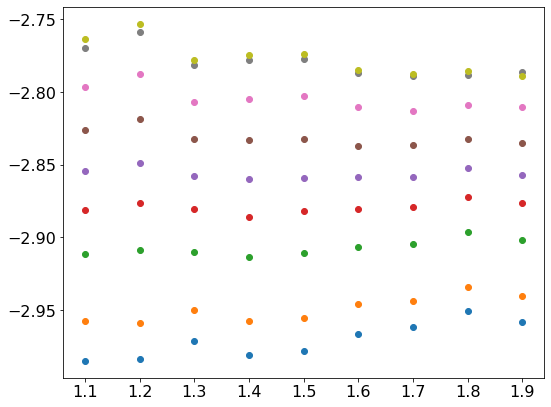

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
x = np.array([[1.1 + idx*0.1 for idx in range(lhmap.shape[0])] for _ in range(lhmap.shape[1])]).T

ax.plot(x, lhmap.T, 'o')
fig.tight_layout()
plt.show()

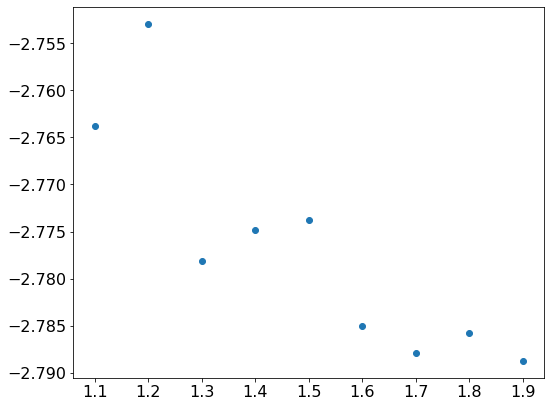

In [52]:
idx = 8
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x.T[idx], lhmap[idx], 'o')
fig.tight_layout()
plt.show()

In [26]:
unbinned_loglh(rg, model1, sample1) / sample1.shape[0]

-2.827896221923828

In [27]:
unbinned_loglh(rg, model1, sample2) / sample2.shape[0]

-2.9651214492797853

In [28]:
unbinned_loglh(rg, model2, sample2) / sample2.shape[0]

-2.9882275650024415

In [29]:
unbinned_loglh(rg, model2, sample1) / sample1.shape[0]

-2.7994251037597655